<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/GenerativeModels/GalaxyMorphologyVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019-2021 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Generative Modeling of Galaxy Images

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this tutorial, we learn how to combine Keras, TensorFlow Probability, and Google Colab to train a model photo-z inference in the cloud.

We will be using data from the HSC Survey, and more specifically from the Public Data Release 2, which can be found here: https://hsc-release.mtk.nao.ac.jp/doc/


The dataset contains postage stamps of galaxies in 5 HSC bands, along with corresponding spectroscopic redshifts.

Our goal will be to model the images contained in this dataset. 


### Instructions for enabling GPU access

By default, notebooks are started without acceleration. To make sure that the runtime is configured for using GPUs, go to `Runtime > Change runtime type`, and select GPU in `Hardware Accelerator`.



### Installs and Imports

In [ ]:
# Retrieving utilities
!git clone https://github.com/EiffL/Tutorials.git
%cd Tutorials/GenerativeModels

# Retrieving pre-prepared data, it takes 2 minutes.
!gsutil -m -q cp -r gs://ahw2019/hsc_photoz/tensorflow_datasets /root/ 

Cloning into 'Tutorials'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 188 (delta 74), reused 12 (delta 4), pack-reused 57
Receiving objects: 100% (188/188), 7.87 MiB | 7.19 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/Tutorials/GenerativeModels


### Checking for GPU access

In [ ]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Building a tf.data.Dataset Input Pipeline

The first step is to read the data from the tfrecords format on disk into a tf.data.Dataset. This TensorFlow API is the canonical way to supply data to a model during training. It is fast and optimized, and supports distributed training!


In [ ]:
import tensorflow_datasets as tfds
import hsc_photoz

train_dset = tfds.load('hsc_photoz', split='train')

### Dataset preprocessing

An important step of any input pipeline is to make
sure the data is reasonably well behaved before 
feeding to the neural network. Here are some common strategies:


*   Apply log() to values with large dynamic range
*   Remove means, and standardize standard deviation
*   etc...


So, we begin by looking at our data


In [ ]:
# What's in our dataset:
train_dset

<PrefetchDataset shapes: {attrs: {a_g: (), a_i: (), a_r: (), a_y: (), a_z: (), d_mag: (), d_pos: (), g_cmodel_dev_flux: (), g_cmodel_dev_fluxsigma: (), g_cmodel_dev_mag: (), g_cmodel_dev_magsigma: (), g_cmodel_exp_flux: (), g_cmodel_exp_fluxsigma: (), g_cmodel_exp_mag: (), g_cmodel_exp_magsigma: (), g_cmodel_flux: (), g_cmodel_fluxsigma: (), g_cmodel_mag: (), g_cmodel_magsigma: (), g_extendedness_value: (), g_localbackground_flux: (), g_sdssshape_psf_shape11: (), g_sdssshape_psf_shape12: (), g_sdssshape_psf_shape22: (), g_sdssshape_shape11: (), g_sdssshape_shape12: (), g_sdssshape_shape22: (), i_cmodel_dev_flux: (), i_cmodel_dev_fluxsigma: (), i_cmodel_dev_mag: (), i_cmodel_dev_magsigma: (), i_cmodel_exp_flux: (), i_cmodel_exp_fluxsigma: (), i_cmodel_exp_mag: (), i_cmodel_exp_magsigma: (), i_cmodel_flux: (), i_cmodel_fluxsigma: (), i_cmodel_mag: (), i_cmodel_magsigma: (), i_extendedness_value: (), i_localbackground_flux: (), i_sdssshape_psf_shape11: (), i_sdssshape_psf_shape12: (), i_s

Ok, we see that this dataset is a dictionary, field `inputs` are hsc cutouts in 5 bands (g,r,i,z,y), this will be the inputs to our CNN. We also see a `specz_redshift` entry, that will be our prediction target. Let's have a look at these.

Populating the interactive namespace from numpy and matplotlib


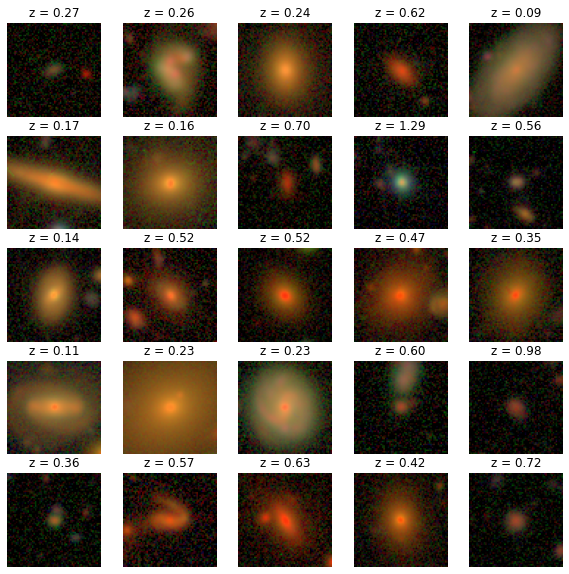

In [ ]:
from astropy.visualization import make_lupton_rgb
%pylab inline 

# The data is in 5 bands GRIZY, but for visualisation we use only the
# 3 first bands and luptonize them
def luptonize(img):
  return make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0],
                         Q=15, stretch=0.5, minimum=0)

plt.figure(figsize=(10,10))
for i, entry in enumerate(train_dset.take(25)):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(entry['image']))
  plt.title('z = %0.02f'%entry['attrs']['specz_redshift'])
  plt.axis('off')

How nice is that :-) We can extract postage stamps and the corresponding spectroscopic redshift for these objects. 

Before doing anything else, we should take a closer look at the  data and check that it's well behaved.

In [ ]:
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(train_dset.take(1000)):
  specz.append(entry['attrs']['specz_redshift'])
  cutouts.append(entry['image'])

cutouts = np.stack(cutouts)
specz = np.stack(specz)

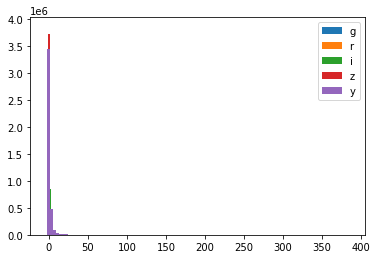

In [ ]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b);
plt.legend()

# Problem ?

This is terrible, the tail of this distribution in pixel intensity is going to kill our neural networks. We need to standardize the data.

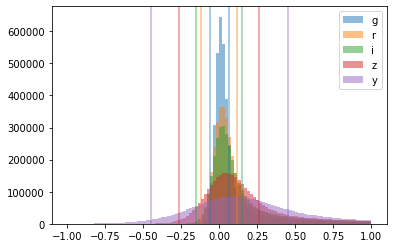

In [ ]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5,range=[-1,1]);
  sigma = mad_std(cutouts[...,i].flatten())
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()

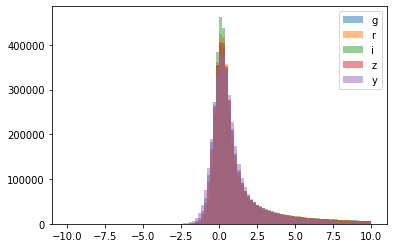

In [ ]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
legend()

Sweet! Now there is still an unsigthly tail towards very large values. We are going to apply range compression to get rid of it.

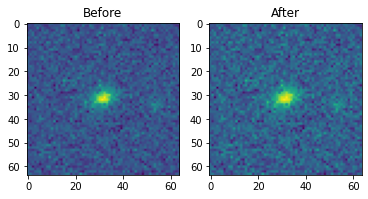

In [ ]:
# we can have a look at individual postage stamps with or without this scaling
subplot(121)
imshow(cutouts[0,:,:,1]/scaling[1])
title('Before')
subplot(122)
imshow(np.arcsinh(cutouts[0,:,:,1]/scaling[1]/3))
title('After');

Now that we have defined a scaling for the data that should be appropriate, we can build a scaling function and apply it to the dataset:

### Create the input pipeline

Now that we know how to preprocess the data, we can build the input pipeline. Below is a function that creates a Dataset object from the tfrecords files, decode them, applies preprocessing, shuffles the dataset, and create batches of data. Finally the function returns the dataset, that Keras models can directly ingest.

More information about tf.data.dataset API can be found here: 

https://www.tensorflow.org/guide/datasets


In [ ]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
  img = tf.math.asinh(example['image'] / tf.constant(scaling) / 3. )
  # We return the image as our input and output for a generative model
  return img, img

def input_fn(mode='train', batch_size=64):
  """
  mode: 'train' or 'test'
  """
  if mode == 'train':
    dataset = tfds.load('hsc_photoz', split='train[:80%]')
    dataset = dataset.repeat()
    dataset = dataset.shuffle(10000)
  else:
    dataset = tfds.load('hsc_photoz', split='train[80%:]')
    
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.map(preprocessing) # Apply data preprocessing
  dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
  return dataset

In [ ]:
dset = input_fn()

## Building a VAE with Keras

Now that have access to training data, let's build a small Variational Auto-Encoder to try to learn how to sample galaxy images.

### Defining a recognition model


In [ ]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfkl = tf.keras.layers
tfd = tfp.distributions

def get_probabilistic_encoder(latent_dim=32):
  """ Creates a small convolutional encoder for the requested latent dimension
  """
  # We choose a prior distribution for the latent codes
  prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

  return tf.keras.Sequential([ 
      tfkl.Input(shape=(64,64,5)),

            # TODO: Write a recognition model.
            # Remember, the output needs to be a distribution, and needs to include 
            # the KL regularisation term
      ])

In [ ]:
prob_encoder = get_probabilistic_encoder(latent_dim=32)

In [ ]:
prob_encoder.summary()

In [ ]:
for batch_im, batch_target in dset.take(1): # Sample only one batch of images
  batch_encoded = prob_encoder(batch_im)    # Apply the encoder on images 

In [ ]:
batch_encoded

### Implementing a generator

One of the important considerations for the generator is, what likelihood to use.

Contrary to an MNIST example, we are dealing here with continuous images, with Gaussian noise, we will therefore choose to use a Gaussian likelihood at the output of the generator. As we have standardized our images, the standard deviation of the noise is 1, and we can directly use that knowledge in the definition of the model.

In [ ]:
def get_probabilistic_decoder(latent_dim=32):
  """ Creates a small convolutional decoder for the requested latent dimension
  """
  return tf.keras.Sequential([
      # TODO: Write a decoder 
      
      # .....

      # This will be the output distribution layer that defines the likelihood
      # Note that we set sigma=0.3 which is around the standard deviation of the 
      # noise in the images after our preprocessing
      tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t,
                                              scale_identity_multiplier=0.3))
  ])

In [ ]:
# Let's instantiate the decoder
prob_decoder = get_probabilistic_decoder(latent_dim=32)
# And check its summary
prob_decoder.summary()

In [ ]:
# Draw a radom sample of the code
code_sample = batch_encoded.sample()
# And decode that sample
decoded_im = prob_decoder(code_sample)

In [ ]:
decoded_im

In [ ]:
figure(figsize=(9,3))
subplot(131)
imshow(batch_im[0,:,:,0],cmap='gray'); axis('off')
title("Input Image")
subplot(132)
imshow(decoded_im.sample()[0,:,:,0],cmap='gray'); axis('off')
title("Sample from generator output")
subplot(133)
imshow(decoded_im.mean()[0,:,:,0],cmap='gray'); axis('off')
title("Mean of generator output");

### Building the VAE

In [ ]:
vae = tf.keras.Sequential([
          tfkl.InputLayer([64,64,5]),
          prob_encoder,
          prob_decoder])

In [ ]:
vae.summary()

In [ ]:
# We define the reconstruction loss as the negative log likelihood
negloglik = lambda x, rv_x: -rv_x.log_prob(x)
# And use it to compile the VAE
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

In [ ]:
# We define the batch size
BATCH_SIZE = 64

# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

In [ ]:
# We actually create our training dataset with our input function
dataset_training = input_fn()

In [ ]:
# We are ready to train our model
history = vae.fit(dataset_training,
            steps_per_epoch=20000//BATCH_SIZE, 
            epochs=15,
            callbacks=[lr_decay])

### Testing VAE auto-encoding

In [ ]:
# Now that the model is 'trained', we can apply it
dataset_eval = input_fn('test')

In [ ]:
for batch_im, batch_targets in dataset_eval.take(1):
  # This extracts one batch of the test dset and shows the first example
  imshow((batch_im[0,:,:,::-1][:,:,-3:]/batch_im[0,:,:,:3].numpy().max()))

In [ ]:
autoencoded_im = vae(batch_im) # Run the input batch through the model

In [ ]:
subplot(121)
# Plot the mean of the output Bernoulli distribution
imshow(autoencoded_im.mean()[0,:,:,-3:]/autoencoded_im.mean()[0,:,:,-3:].numpy().max(),cmap='gray'); axis('off'); 
title('Mean output')
subplot(122)
# Plot a random sample of the output Bernoulli distribution
imshow(autoencoded_im.sample()[0,:,:,0],cmap='gray'); axis('off');
title('Sample output');

### Sampling from the model

In [ ]:
latent_samples = tfd.MultivariateNormalDiag(loc=tf.zeros(32)).sample(16)

In [ ]:
image_samples = prob_decoder(0.5*latent_samples)

In [ ]:
figure(figsize=(10,10))
fig = image_samples.mean().numpy().reshape((4,4,64,64,5))
fig = fig.transpose((0,2,1,3,4)).reshape((4*64,4*64,5))
# Let's see the result
imshow(fig[:,:,::-1][:,:,-3:]/(fig[:,:,::-1][:,:,-3:]).max()); axis('off');